In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q
!pip install xrft --upgrade -q

# Dask start

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41455")

# Import

In [5]:
import sys
sys.path.insert(1, '..')

In [6]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe

# Plotting params

In [7]:
#%matplotlib widget
%matplotlib inline

In [8]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [9]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys']

In [10]:
marker_list = ['o', '^', 's', 'D', 'X', '>']

# Useful functions for histograms

In [11]:
def compute_1D_histogram(dataSet, var1, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
    else :
        bins1 = bins
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), bins=[bins1], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [12]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None, normalize=False) :
    if normalize :
        variable1_to_use = (dataSet[var1]-dataSet[var1].mean())#/dataSet[var1].std()
        variable2_to_use = (dataSet[var2]-dataSet[var2].mean())#/dataSet[var2].std()
    else :
        variable1_to_use = dataSet[var1]
        variable2_to_use = dataSet[var2]   
    if bins is None :
        bins1 = np.linspace(variable1_to_use.min(), variable1_to_use.max(), nb_of_bins)
        bins2 = np.linspace(variable2_to_use.min(), variable2_to_use.max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(variable1_to_use.fillna(0), variable2_to_use.fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [13]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index], marker='.', ls='-', ms=1.5)
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

## Distance between histograms

- Cross-entropy:
$$ H(P,Q) \equiv - \sum_i P(i) \log Q(i) $$
- Self-entropy:
$$H(P) \equiv - \sum_i P(i) \log P(i)$$

In [14]:
def H(hist_P, hist_Q) :
    #masked_P = np.where(hist_P >0, hist_P, np.NaN)
    masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    return -np.nansum(hist_P*(np.log(masked_Q)))

- Kullback-Leibler (KL) divergence (or relative entropy) 
$$ D_{KL} (P || Q) = H(P, Q) - H(P) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
a measure of how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.

In [15]:
def D_KL(hist_P, hist_Q) :
    #masked_P = np.where(hist_P >0, hist_P, np.NaN)
    #masked_Q = np.where(hist_Q >0, hist_Q, np.NaN)
    #return np.nansum(masked_P*(np.log(masked_P/masked_Q)))
    return H(hist_P, hist_Q)-H(hist_P, hist_P)

- Symmertrized KL divergence (Jeffreys divergence):
$$ D_{sym} (P || Q) = D_{KL} (P || Q) + D_{KL} (Q || P) $$

In [16]:
def D_sym(hist_P, hist_Q) :
    return D_KL(hist_P, hist_Q)+D_KL(hist_Q, hist_P)

# Load data

Choose cases

In [17]:
data=[dict() for i in range(6)]

In [18]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

## eNATL60

In [19]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [20]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,150),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [21]:
nb_of_time_chunks = 4

In [22]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set
    data[i]['HR'].attrs['source'] = 'eNATL60'

CPU times: user 2.69 s, sys: 978 ms, total: 3.67 s
Wall time: 1min 19s


## eORCA025

In [23]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("../Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).rename(nav_lat='lat', nav_lon='lon')
    data[i]['LR'].attrs['source'] = 'eORCA025'

# Filters

## Routines

In [24]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binarize and erode the mask (to remove isolated pixels)
    threshold = 0.0
    new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    #apply new mask to data
    result = result.where(result.tmask>0)
    return result

In [25]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    data = dataHR.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    wet_mask = xr.DataArray(data.tmask, dims=['y','x'])
    area = xr.DataArray((data.e1t * data.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(data.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(data.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(data.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(data.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=data.coords)
        data_filtered = gaussian_filter.apply(data, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=data.coords)
        data_filtered = data
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [26]:
coarsening_window_size = 15
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Coarse to 0.25°'}),
          dict({'filter_coef' : 7.5, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Filter 0.125° + Coarse to 0.25°'}),
          dict({'filter_coef' : 15, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Filter 0.25° + Coarse to 0.25°'}),
          dict({'filter_coef' : 30, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Filter 0.5° + Coarse to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 2*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 0.5° + Interp to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : 4*coarsening_window_size, 'interpolate' : True, 'label' : 'Coarse to 1° + Interp to 0.25°'})]

In [27]:
regrid_method = 'bilinear'

In [28]:
%%time
%%capture --no-display
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = [] 
    ref_data = data[i]['LR']
    out_grid = xr.DataArray(coords={'lon' : ref_data.lon, 'lat' : ref_data.lat, 'x': ref_data.x, 'y': ref_data.y}, dims=['y', 'x'])
    for ifilter, curr_filter in enumerate(filters) :
        filtered = apply_filter_downsample(data[i]['HR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
                                                               chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        if (curr_filter['interpolate']):
            regridder = xe.Regridder(filtered, out_grid, regrid_method, unmapped_to_nan=True)
            regridded = regridder(filtered)
            regridded.coords['e1t'] = ref_data.e1t
            regridded.coords['e2t'] = ref_data.e2t
            data[i]['HR_Filtered'].append(regridded)
        else :
            data[i]['HR_Filtered'].append(filtered)

CPU times: user 42.7 s, sys: 8.85 s, total: 51.5 s
Wall time: 4min 19s


# Method

## Quantities used to compare eORCA025 with filtered eNATL60

The squares of finite differences $|\delta \textbf{x} \cdot \nabla \overline{T}|^2$ and $|\delta \textbf{x} \cdot \nabla \overline{S}|^2$ are good candidates for statistical testing of the spatial filtering procedures because:
- They are used as predictors for subgrid variance in previous studies.
If we are capable to 
- They are sensitive to "smoothness" of the fields and to the choice of the filter
- Easy to extract

## Use KL divergence as metrics for detection of under- or over-fitting situations

- Kullback-Leibler (KL) divergence (or relative entropy)  is defined as:
$$ D_{KL} (P || Q) = \sum_i P(i) \log\frac{P(i)}{Q(i)} $$
It measures how one probability distribution $Q$ is different from a second, reference probability distribution $P$ (information gain of $P$ in comparison to $Q$). In other words, it is the amount of information lost when $Q$ is used to approximate $P$.
At the same time, one can see that in a general case $D_{KL}$ can be negative, in particular when there is a significant contribution from bins $i$ where $Q(i)>P(i)$. We can use the sign and proximity to 0 of $D_{KL}$ as an indicator of over- or under-fitting cases, in particular:
- if $ D_{KL} \approx 0 $ the two distributions contain more or less the same information, the divergence is small. This would be the case of "ideal" filter, when filtered data reproduces correctly the considered stats of the reference data.
- if $ D_{KL} < 0 $ the information content of the referential distribution $P$ is <b>larger</b>. If we put eORCA025 distributions as the reference $P$ this case would correspond to the situation when ORCA025 data contains a larger variety of gradients comparing to the filtered eNATL60 data. This case would correspond to <i> over-filtering </i>, as some features presented in LR data are lost due to filtering, and it should be <b>avoided</b>.
- if $ D_{KL} > 0 $ the reference distribution $P$ contains less information than the approximating distribution $Q$. In other words, the filtered fields still contain some features from HR data, not represented in LR-simulation data. This case would correspond to <i> under-filtering</i>. But this situation should be acceptable, because the most important is that the filtered data contains the small-scale features that can appear in ORCA025. If it contains some more events, like some stronger gradients absent in ORCA025, it should not be an issue, since the parametrization will adapt to weaker gradients.

The main idea is to find such a filter that would <b>not allow over-filtering</b> in none of the data sets (in all regions and seasons). At the same time, the situation with under-filtering should be considered as acceptable. Therefore, we will look for a filter that gives $ D_{KL} \approx 0 $ or $ D_{KL} > 0 $ in all datasets, but not negative.

# Statistics of the finite differences

Finite-difference evaluation of squares of the local gradients:
$$ \Delta_x T(x,y)\equiv \frac{1}{2} \left[\overline{T}(x+\Delta x, y) - \overline{T}(x - \Delta x, y)\right] $$
$$ \Delta_y T(x,y)\equiv \frac{1}{2} \left[\overline{T}(x, y+\Delta y) - \overline{T}(x, y- \Delta y)\right] $$
$$ |\delta x \cdot \nabla \overline{T}|^2 (x,y) \equiv [\Delta_x T(x,y)]^2 + [\Delta_y T(x,y)]^2 $$
and the same for salinity.

In [29]:
# def diffs_x(dataArray) :
#     return (dataArray.shift(x=-1) - dataArray)
# def diffs_y(dataArray) :
#     return (dataArray.shift(y=-1) - dataArray)
def central_diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def central_diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [30]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["diff_x_T"] = central_diffs_x(ds['sosstsst'])
        ds["diff_y_T"] = central_diffs_y(ds['sosstsst'])
        ds["diff_x_S"] = central_diffs_x(ds['sosaline'])
        ds["diff_y_S"] = central_diffs_y(ds['sosaline'])
        ds["diff_T_sqr"] = ds["diff_x_T"]**2 + ds["diff_y_T"]**2
        ds["diff_S_sqr"] = ds["diff_x_S"]**2 + ds["diff_y_S"]**2

CPU times: user 2.64 s, sys: 11.3 ms, total: 2.65 s
Wall time: 2.64 s


In [31]:
x_slice = slice(1,-1)
y_slice = slice(1,-1)
bord_cut = dict(y=y_slice,x=x_slice) # to cut borders 

In [32]:
nb_of_bins = 150

In [33]:
# initialize data structure for storing histograms
hists=[dict() for i in range(len(data))]
for i in range(len(data)) :
    hists[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    hists[i]['HR'] = dict({'label' : 'eNATL60'})
    hists[i]['LR'] = dict({'label' : 'eORCA025'})

## 1D histograms

In [34]:
%%time
normalized = False
for variable in ["diff_T_sqr", "diff_S_sqr"] :
    for i in range(len(data)) :
        #ref_hist = compute_1D_histogram(data[i]['HR_Filtered'][2][bord_cut], variable, nb_of_bins, bins=None).compute()
        ref_hist = compute_1D_histogram(data[i]['LR'], variable, nb_of_bins, bins=None).compute()
        ref_bins = ref_hist[variable+'_bin'].data
        
        hists[i]['LR'][variable] = compute_1D_histogram(data[i]['LR'][bord_cut], variable, nb_of_bins, bins=ref_bins).compute()

        for ifilter in range(len(filters)) :
            hists[i]['HR_Filtered'][ifilter][variable] = compute_1D_histogram(data[i]['HR_Filtered'][ifilter][bord_cut], variable, nb_of_bins, bins=ref_bins)

CPU times: user 4.48 s, sys: 92.4 ms, total: 4.57 s
Wall time: 18.3 s


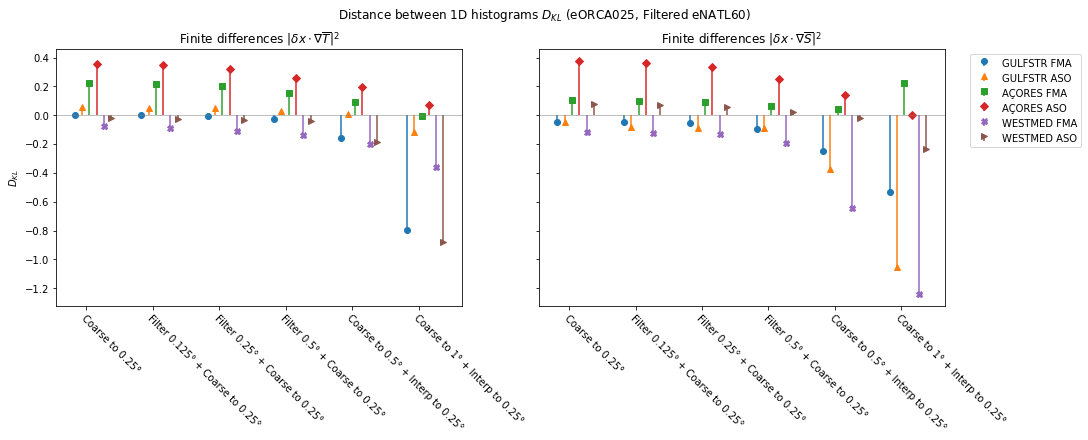

CPU times: user 3.45 s, sys: 383 ms, total: 3.83 s
Wall time: 17.1 s


In [35]:
%%time
fig, axis = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 6), sharey=True)
fig.suptitle('Distance between 1D histograms $D_{KL}$ (eORCA025, Filtered eNATL60)')
x = np.arange(len(filters))
bar_width = 0.11
for i_dataset in range(len(data)) :
    marker_style = 'C'+str(i_dataset)+marker_list[i_dataset]
    line_style = 'C'+str(i_dataset)+'-'
    markerline, stemlines, baseline = axis[0].stem(x+(i_dataset)*bar_width, [D_KL(hists[i_dataset]['LR']['diff_T_sqr'], hists[i_dataset]['HR_Filtered'][ifilter]['diff_T_sqr']) \
                                          for ifilter in range(len(filters))], markerfmt=marker_style, basefmt=" ", linefmt=line_style)
    markerline, stemlines, baseline = axis[1].stem(x+(i_dataset)*bar_width, [D_KL(hists[i_dataset]['LR']['diff_S_sqr'], hists[i_dataset]['HR_Filtered'][ifilter]['diff_S_sqr']) \
                                          for ifilter in range(len(filters))], markerfmt=marker_style, basefmt=" ", linefmt=line_style, label=data[i_dataset]['label'])
for ax in axis :
    ax.set_xticks(x + 1.6*bar_width)
    ax.set_xticklabels([filt['label'] for filt in filters],fontsize=10,rotation = -45,ha="left", rotation_mode="anchor")
    ax.set(yscale='linear')
    ax.axhline(y=0., color='grey', ls='-', lw=0.5)
    #ax.set(ylim=[-0.2,0.2])
axis[0].set(title=r'Finite differences $|\delta x \cdot \nabla \overline{T}|^2$', ylabel=r'$D_{KL}$')
axis[1].set(title=r'Finite differences $|\delta x \cdot \nabla \overline{S}|^2$')
axis[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Case of similar distributions $(D_{KL} \approx 0)$

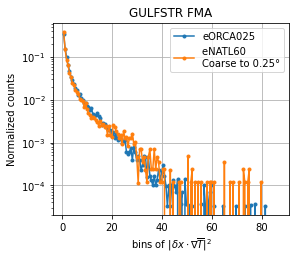

In [36]:
ifilter = 0 # pure coarse
region = 0
quantity='diff_T_sqr'

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.5), sharey=True)
hists[region]['LR'][quantity].plot(ax=ax, ls='-', marker='.', label='eORCA025')
hists[region]['HR_Filtered'][ifilter][quantity].plot(ax=ax, ls='-', marker='.', label='eNATL60 \n'+filters[ifilter]['label'])

ax.set(title=data[region]['label'], xlabel=r'bins of $|\delta x \cdot \nabla \overline{T}|^2$', ylabel='Normalized counts')
ax.set(yscale='log')
ax.grid(True)
ax.legend()
plt.show()

## Case of overfiltering $(D_{KL} < 0)$

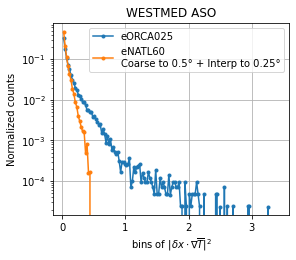

In [46]:
ifilter = 4
region = 5
quantity='diff_T_sqr'

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.5), sharey=True)
hists[region]['LR'][quantity].plot(ax=ax, ls='-', marker='.', label='eORCA025')
hists[region]['HR_Filtered'][ifilter][quantity].plot(ax=ax, ls='-', marker='.', label='eNATL60 \n'+filters[ifilter]['label'])

ax.set(title=data[region]['label'], xlabel=r'bins of $|\delta x \cdot \nabla \overline{T}|^2$', ylabel='Normalized counts')
ax.set(yscale='log', xscale='linear')
ax.grid(True)
ax.legend()
plt.show()

## Case of underfiltering $(D_{KL} > 0)$

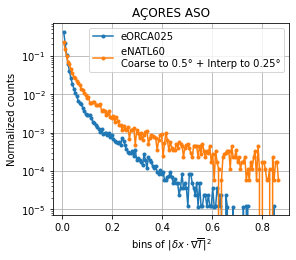

In [38]:
ifilter = 4
region = 3
quantity='diff_T_sqr'

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4, 3.5), sharey=True)
hists[region]['LR'][quantity].plot(ax=ax, ls='-', marker='.', label='eORCA025')
hists[region]['HR_Filtered'][ifilter][quantity].plot(ax=ax, ls='-', marker='.', label='eNATL60 \n'+filters[ifilter]['label'])

ax.set(title=data[region]['label'], xlabel=r'bins of $|\delta x \cdot \nabla \overline{T}|^2$', ylabel='Normalized counts')
ax.set(yscale='log', xscale='linear')
ax.grid(True)
ax.legend()
plt.show()

# Spectra

In [39]:
# without interpolation
def prepare_data_for_spec(data, variable) :
    res = data[variable].dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    
    if ("e1t" in data) :
        delta_x = res['e1t'].mean(skipna=True).values
        delta_y = res['e2t'].mean(skipna=True).values
    else :
        delta_x = gsw.distance(data.lon,data.lat).mean(skipna=True)
        delta_y = gsw.distance(data.lon,data.lat).mean(skipna=True)
        
    res.coords['x'] = res.coords['x']*delta_x
    res.coords['y'] = res.coords['y']*delta_y 

    # fill in nans
    # avg = step0.mean().compute()
    # data_filled_nans = interpolated_field.fillna(avg)
    res = res.interpolate_na(dim="x", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="y", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")

    res = res.drop(['depth', 'e1f', 'e1u', 'e1v', 'e2f', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon', 'e1t', 'e2t'], errors='ignore')
    return res

In [40]:
def wrapper_xrtf_isotropic_PS(data, variable, binning_factor=4) :
    #prepared_data = uniform_grid_interpolation(data.drop(['tmask']), variable) # with interpolation on a uniform grid
    prepared_data = prepare_data_for_spec(data.drop(['tmask'], errors='ignore'), variable) # without interpolation 
    isotropic_power_spec = xrft.isotropic_power_spectrum(prepared_data, dim=['x','y'], detrend='linear', nfactor=2, truncate=True)
    return isotropic_power_spec.rename('Spatial_spectrum')

In [41]:
# initialize data structure for storing spectra
spec=[dict() for i in range(len(data))]
for i in range(len(data)) :
    spec[i]['HR_Filtered'] = [dict({'label' : filters[ifilter]['label']}) for ifilter in range(len(filters))] 
    spec[i]['HR'] = dict({'label' : 'eNATL60'})
    spec[i]['LR'] = dict({'label' : 'eORCA025'})

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
%%time 
for quantity in ['sosstsst', 'sosaline'] :
    for i in range(len(data)) :
        for key_dict in ['LR', 'HR'] :
            spec[i][key_dict][quantity] = (wrapper_xrtf_isotropic_PS(data[i][key_dict], quantity)).mean(dim='time_counter').compute()
        for ifilter in range(len(filters)) :
            spec[i]['HR_Filtered'][ifilter][quantity] = (wrapper_xrtf_isotropic_PS(data[i]['HR_Filtered'][ifilter], quantity)).mean(dim='time_counter').compute()

CPU times: user 1min 24s, sys: 3.57 s, total: 1min 27s
Wall time: 4min 57s


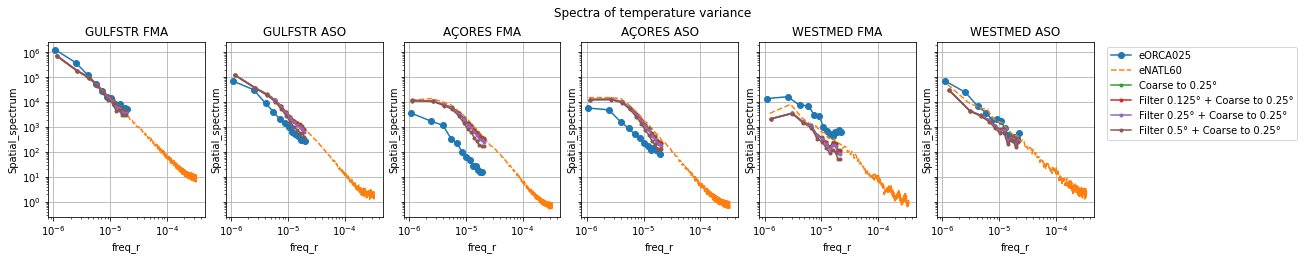

In [47]:
fig, ax = plt.subplots(ncols=6, constrained_layout=True, figsize=(18,3.5), sharex=True, sharey=True)
fig.suptitle('Spectra of temperature variance')
for data_i in range(len(data)) :
    spec[data_i]['LR']['sosstsst'].plot(x='freq_r', ax=ax[data_i], marker='o', label='eORCA025')
    spec[data_i]['HR']['sosstsst'].plot(x='freq_r', ax=ax[data_i], ls='--', label='eNATL60')
    #for ifilter in range(len(filters)) :
    for ifilter in range(4) :
        spec[data_i]['HR_Filtered'][ifilter]['sosstsst'].plot(x='freq_r', marker='.', ax=ax[data_i], label=filters[ifilter]['label'])
    ax[data_i].set(title=data[data_i]['label'], xscale='log', yscale='log'); ax[data_i].grid(True)
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

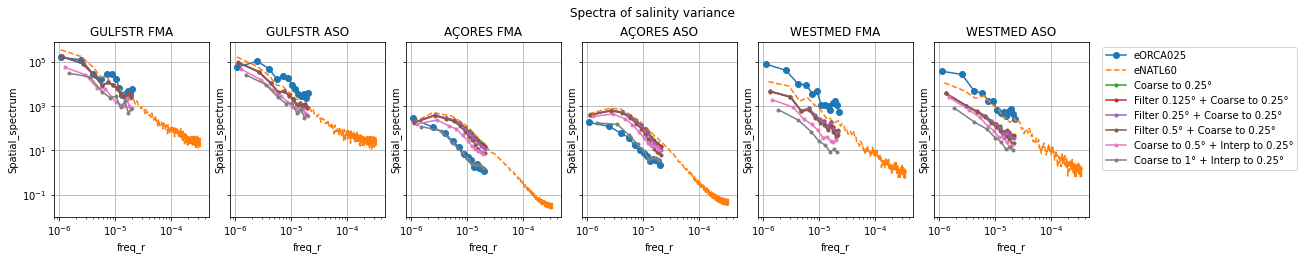

In [45]:
fig, ax = plt.subplots(ncols=6, constrained_layout=True, figsize=(18,3.5), sharex=True, sharey=True)
fig.suptitle('Spectra of salinity variance')
for data_i in range(len(data)) :
    spec[data_i]['LR']['sosaline'].plot(x='freq_r', ax=ax[data_i], marker='o', label='eORCA025')
    spec[data_i]['HR']['sosaline'].plot(x='freq_r', ax=ax[data_i], ls='--', label='eNATL60')
    for ifilter in range(len(filters)) :
        spec[data_i]['HR_Filtered'][ifilter]['sosaline'].plot(x='freq_r', marker='.', ax=ax[data_i], label=filters[ifilter]['label'])
    ax[data_i].set(title=data[data_i]['label'], xscale='log', yscale='log'); ax[data_i].grid(True)
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()